<a href="https://colab.research.google.com/github/ayush12gupta/GAN-Implementations/blob/master/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



In [0]:
mb_size = 64

img_size = 64
transform = transforms.Compose([
        transforms.Scale(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))])
        

trainLoader = torch.utils.data.DataLoader(
    datasets.FastionMNIST('data', train=True, download=True, transform=transform),
    batch_size=64, shuffle=True)

# transform = transforms.ToTensor()

# trainData = torchvision.datasets.MNIST('./data/', download=True, transform=transform, train=True)

# trainLoader = torch.utils.data.DataLoader(trainData, shuffle=True, batch_size=mb_size)

/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:220: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


AttributeError: ignored

In [0]:
dataIter = iter(trainLoader)

imgs, labels = dataIter.next()

In [0]:
print(imgs.shape)

torch.Size([64, 3, 64, 64])


In [0]:
def imshow(imgs,epoch):
    imgs = torchvision.utils.make_grid(imgs)
    npimgs = imgs.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    filename = 'epoch_'+str(epoch)+'.png'
    plt.savefig(filename)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


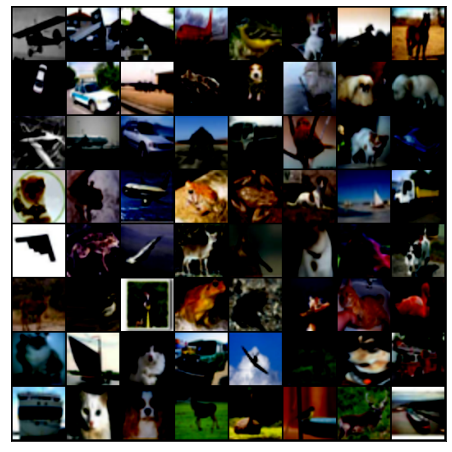

In [0]:
imshow(imgs,0)

In [0]:
Z_dim = 100
H_dim = 128
X_dim = imgs.view(imgs.size(0), -1).size(1)

print(Z_dim, H_dim, X_dim)

device = 'cuda'

100 128 12288


In [0]:
def normal_init(m,mean,std):      
      #for m in self._modules:  
        if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
            m.weight.data.normal_(mean, std)
            m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d):
           torch.nn.init.constant_(m.weight, 1)
           torch.nn.init.constant_(m.bias, 0)    

In [0]:
class generator(nn.Module):
    def __init__(self):
        super(generator,self).__init__()
        self.model = nn.Sequential(nn.ConvTranspose2d(100,128*8,4,1,0), # Output: 14x14
                                   nn.BatchNorm2d(128*8),
                                   nn.ReLU(),
                                   nn.ConvTranspose2d(128*8,128*4,kernel_size=4,stride=2,padding=1), # Output: 14x14
                                   nn.BatchNorm2d(128*4),
                                   nn.ReLU(),
                                   nn.ConvTranspose2d(128*4,128*2,kernel_size=4,stride=2,padding=1), # Output: 7x7
                                   nn.BatchNorm2d(128*2),
                                   nn.ReLU(),
                                   nn.ConvTranspose2d(128*2,128 ,kernel_size = 4 ,stride = 2 ,padding = 1), # Output: 14x14
                                   nn.BatchNorm2d(128),
                                   nn.ReLU(),
                                   nn.ConvTranspose2d(128,3 ,kernel_size = 4 ,stride = 2 ,padding = 1),  ###
                                   nn.Tanh()
                                  )

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, input):
        x = self.model(input)
       # x = x.reshape(-1,28,28)
        return x #.unsqueeze(1)  

In [0]:
class generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))

        return x

In [0]:
gen = generator().to(device)
gen.weight_init(mean=0.0, std=0.2)

In [0]:
print(gen)

generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)


In [0]:
print(gen)

generator(
  (deconv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)


In [0]:
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator,self).__init__()
        self.model = nn.Sequential(nn.Conv2d(3,128,kernel_size=4,stride=2,padding=1), # Output: 14x14  ############
                                   nn.BatchNorm2d(128),
                                   nn.LeakyReLU(0.2,inplace=True),
                                   nn.Conv2d(128,2*128,kernel_size=4,stride=2,padding=1), # Output: 14x14
                                   nn.BatchNorm2d(2*128),
                                   nn.LeakyReLU(0.2,inplace=True),
                                   nn.Conv2d(128*2,128*4,kernel_size=4,stride=2,padding=1), # Output: 7x7
                                   nn.BatchNorm2d(128*4),
                                   nn.LeakyReLU(0.2,inplace=True),
                                   nn.Conv2d(128*4 ,128*8 ,kernel_size = 4 ,stride = 2 ,padding = 1), # Output: 7x7
                                   nn.BatchNorm2d(128*8),
                                   nn.LeakyReLU(0.2,inplace=True),
                                   nn.Conv2d(128*8,1,kernel_size = 4,stride = 1,padding = 0), # Output 1x1
                                   nn.Sigmoid()
                                  ) 
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
            
    def forward(self, x):
        #x = torch.unsqueeze(x,1)
        #x = x.reshape(-1,28*28)
        x = self.model(x)    
        return x #torch.unsqueeze(x,1) 

In [0]:
dis = discriminator().to(device)
dis.weight_init(mean=0.0, std=0.2)

In [0]:
print(dis)

discriminator(
  (model): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
    (13): Sigmoid()

In [0]:
fix_noise = torch.FloatTensor(torch.randn(64, 100, 1, 1)).to(device) # To evaluate on a particular noise
fix_label = torch.LongTensor(np.random.randint(0, 10, batch_size)).to(device)

In [0]:
#loss = torch.nn.BCELoss()

def dis_loss(real_output,fake_output):
    real_loss = F.binary_cross_entropy(real_output,torch.ones_like(real_output).to(device))
    fake_loss = F.binary_cross_entropy(fake_output,torch.zeros_like(fake_output).to(device))
    return fake_loss + real_loss

def gen_loss(fake_output):
    return F.binary_cross_entropy(fake_output,torch.ones_like(fake_output))   #F.binary_cross_entropy

In [0]:
gen_optim = torch.optim.Adam(gen.parameters(), lr=0.0002,betas=(0.4,0.999))
dis_optim = torch.optim.Adam(dis.parameters(), lr=0.0002,betas=(0.4,0.999))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:0,   G_loss:2.8353482270065475,    D_loss:0.8213186944117936


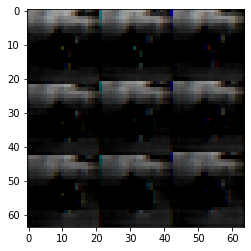

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:1,   G_loss:5.357188928043446,    D_loss:0.3056872114453547


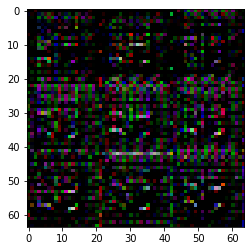

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:2,   G_loss:10.271577180194123,    D_loss:0.002259211283588164


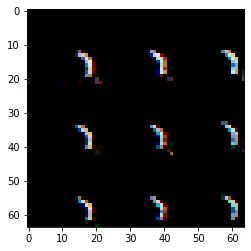

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:3,   G_loss:6.312733572393256,    D_loss:0.45092021759713125


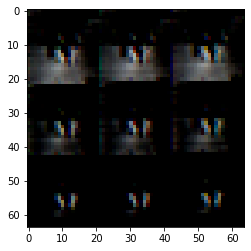

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:4,   G_loss:4.438603647309296,    D_loss:0.5165982175126548


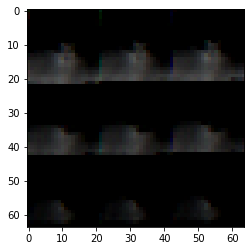

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:5,   G_loss:4.474807380331809,    D_loss:0.42386051931637614


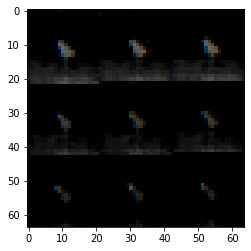

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:6,   G_loss:4.745426666444105,    D_loss:0.43937208051720333


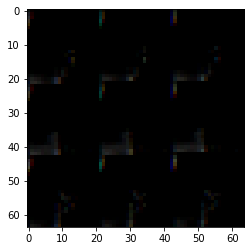

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:7,   G_loss:4.3252939864747235,    D_loss:0.45978646865948236


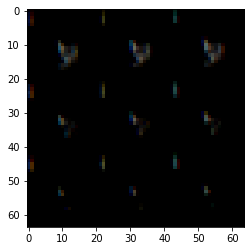

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:8,   G_loss:7.992019296911976,    D_loss:0.007661066192909843


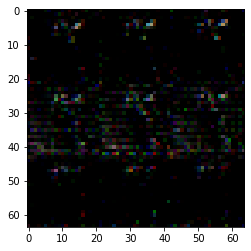

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:9,   G_loss:10.462001744286178,    D_loss:0.1557430145680778


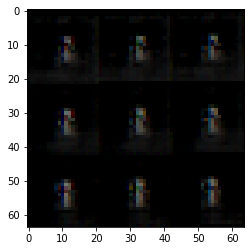

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:10,   G_loss:5.527489974732746,    D_loss:0.3289458156750023


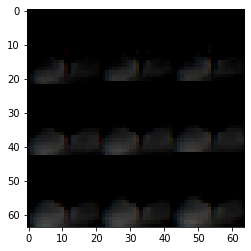

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:11,   G_loss:4.962341813537319,    D_loss:0.31406364413445736


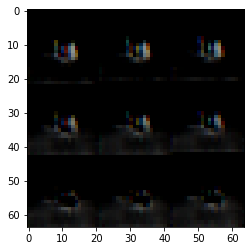

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:12,   G_loss:8.541746230381529,    D_loss:0.004485665045679751


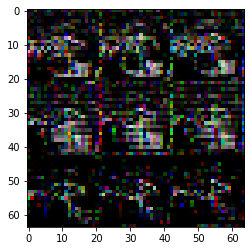

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:13,   G_loss:27.424998538193524,    D_loss:0.028278168110755668


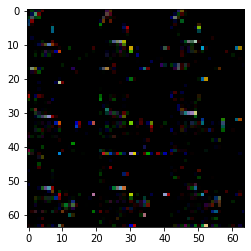

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:14,   G_loss:58.46869478933037,    D_loss:4.535058460249002e-05


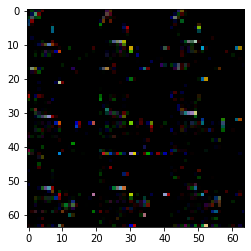

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:15,   G_loss:58.12420619662156,    D_loss:1.0185572961651705e-05


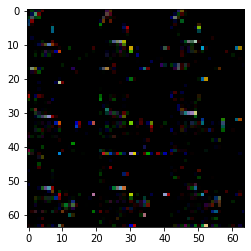

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:16,   G_loss:58.0106235562688,    D_loss:5.583126659283626e-06


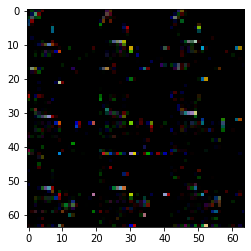

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:17,   G_loss:57.81564370567536,    D_loss:3.4750546818918776e-06


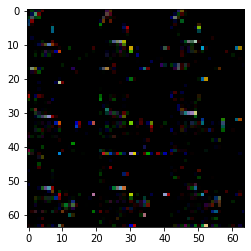

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:18,   G_loss:57.697750701318924,    D_loss:2.3072463318015606e-06


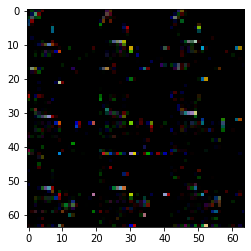

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:19,   G_loss:57.62191495870995,    D_loss:1.227063524685718e-06


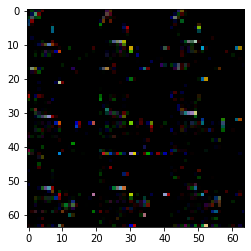

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:20,   G_loss:57.53626600494775,    D_loss:9.175342992108372e-07


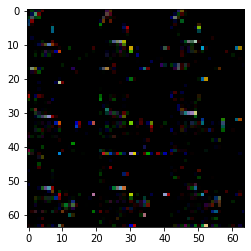

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:21,   G_loss:57.46321844505837,    D_loss:5.886993071305341e-07


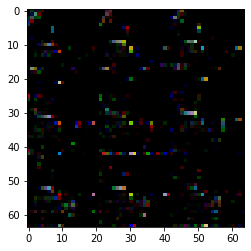

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:22,   G_loss:57.32504766127642,    D_loss:4.50056980761491e-07


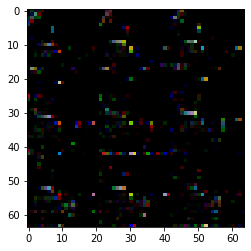

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:23,   G_loss:57.23887357687401,    D_loss:3.4167674807619965e-07


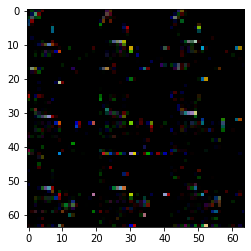

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:24,   G_loss:57.13296258541019,    D_loss:2.125088037186827e-07


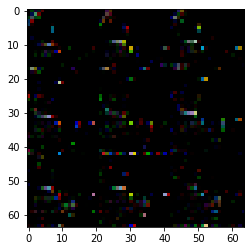

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:25,   G_loss:56.986984989527244,    D_loss:1.3643619281130878e-07


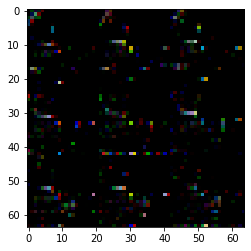

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:26,   G_loss:56.92224029384916,    D_loss:7.675772343106319e-08


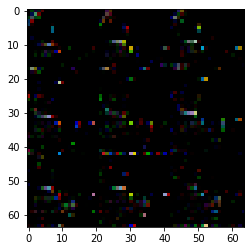

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:27,   G_loss:56.84851113243786,    D_loss:6.178393500022611e-08


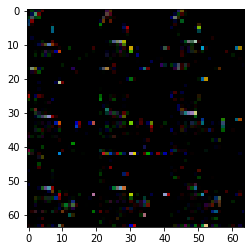

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:28,   G_loss:56.71379882539325,    D_loss:5.405997169495839e-08


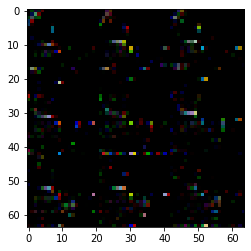

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:29,   G_loss:56.58217329137466,    D_loss:2.74659080869613e-08


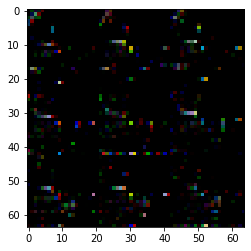

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:30,   G_loss:56.45542197459189,    D_loss:1.968416041616578e-08


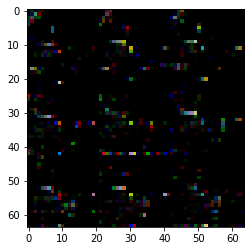

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:31,   G_loss:56.348006148472464,    D_loss:1.242641015434586e-08


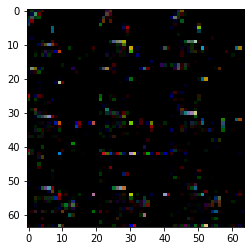

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:32,   G_loss:56.258731173737274,    D_loss:9.07744027004377e-09


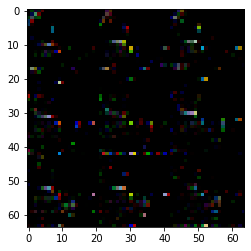

In [0]:
G_Loss = []
D_Loss = []
for epoch in range(40):
    Gt_loss = 0
    Dt_loss = 0
    
    for i, data in enumerate(trainLoader):
        X,_ = data
        #X = X.view(X.size(0), -1).to(device)
        b_size = X.size(0)
        z = torch.randn(b_size, 100, 1, 1).to(device)#torch.randn(mb_size, Z_dim).to(device) 
        X = X.to(device)
        D_real = dis(X).squeeze()
        #print(D_real.size())
        g=gen(z)
        D_fake = dis(g).squeeze()


        D_loss = dis_loss(D_real,D_fake)
 
        dis_optim.zero_grad()
        D_loss.backward()
        dis_optim.step()

        gen_optim.zero_grad()        
        
        z = torch.randn(64, 100, 1, 1).to(device) #torch.randn(mb_size, Z_dim).to(device)
        g=gen(z)
        D_fake = dis(g)
        G_loss =  F.binary_cross_entropy(D_fake,torch.ones_like(D_fake))#gen_loss(D_fake)
        G_loss.backward()
        gen_optim.step()

        Gt_loss += G_loss.item()
        Dt_loss += D_loss.item()
        
    print('Epoch:{},   G_loss:{},    D_loss:{}'.format(epoch, Gt_loss/(i+1), Dt_loss/(i+1)))
    D_Loss.append(Dt_loss/(i+1))
    G_Loss.append(Gt_loss/(i+1))
    plt.imshow(gen(fix_noise)[0].squeeze().detach().cpu().view(64,64,3), cmap='gray')
    plt.show()
    samples = gen(fix_noise).detach()
    samples = samples.view(samples.size(0),64, 64,3).cpu()
    #imshow(samples,epoch)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


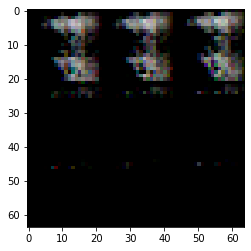

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


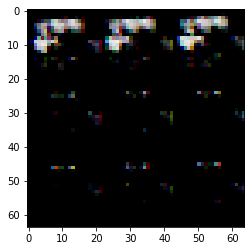

torch.Size([64, 3, 64, 64])   torch.Size([64, 100, 1, 1])   torch.Size([64, 100, 1, 1])   torch.Size([64, 3, 64, 64])


In [0]:
plt.imshow(gen(fix_noise)[12].squeeze().detach().cpu().view(64,64,3))
plt.show()
plt.imshow(gen(fix_noise)[60].squeeze().detach().cpu().view(64,64,3))
plt.show()
print(gen(z).size()," ",z.shape," ",fix_noise.shape," ",gen(fix_noise).size())